# 05a2 – Enhanced 3-Step Floating Catchment Area (E3SFCA) Scenario Modelling

## Overview

This notebook implements the **Enhanced 3-Step Floating Catchment Area (E3SFCA)** model to estimate spatial accessibility to CT scanner services across LSOAs in England. The E3SFCA method builds on the traditional 2SFCA by incorporating:

- Decay functions based on **realistic travel time bands** (car mode),
- **Weighted supply-to-demand ratios** per MRI site (Rⱼ),
- **Aggregated accessibility scores (Fᵢ)** for each LSOA, reflecting cumulative opportunity adjusted for catchment overlap and travel friction.

This model serves as the **baseline scenario** for accessibility modelling prior to adding new sites or testing alternative service distributions.

---

## Key Objectives

- Apply a **stepwise decay function** to account for declining willingness to travel with increasing time.
- Compute supply-to-demand ratios (**Rⱼ**) at each MRI facility using weighted demand from surrounding LSOAs.
- Generate accessibility scores (**Fᵢ**) per LSOA as the sum of all weighted contributions from accessible facilities.
- Export all outputs for downstream comparison and mapping (e.g., accessibility delta plots, prioritisation maps).

---

## Input Datasets

- LSOA-level demand estimates and geometry (`gdf_lsoa`)
- CT scanner site locations and capacity (`df_sites_ct`)
- Travel time matrix between all LSOAs and MRI sites by car (`df_travel_car`)

---

## Outputs

The following datasets are exported to `/data/processed/E3SFCA/`:

- LSOA accessibility scores (GeoPackage + CSV)
- Travel matrix with decay weights
- MRI site supply-to-demand ratio table (Rⱼ values)
- MRI site capability table with scanner counts

---

## Planning Utility

The E3SFCA score (Fᵢ) can be used to:

- Identify LSOAs with **low spatial access** to MRI scanning services,
- Support **site placement strategies** by revealing coverage deserts,
- Quantify the impact of **proposed infrastructure** on accessibility equity.

This model underpins scenario testing in subsequent notebooks (`05a3`, `06a`, etc.).


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import os

# Optional
import warnings
warnings.filterwarnings("ignore")


In [2]:
# ----------------------------------------------------------
# Step 1 – Load Baseline E3SFCA Files (Car Mode + Site Types) — MRI
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# E3SFCA input files (MRI-labelled to avoid CT overlap)
lsoa_access_path = os.path.join(processed_dir, "E3SFCA", "lsoa_e3sfca_mri_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(processed_dir, "E3SFCA", "lsoa_to_mri_travel_matrix_car.csv")
mri_sites_path = os.path.join(processed_dir, "E3SFCA", "mri_sites_capability.csv")
rj_path = os.path.join(processed_dir, "E3SFCA", "mri_site_rj_scores_car.csv")

# Load baseline outputs (read the MRI layer explicitly)
gdf_lsoa = gpd.read_file(lsoa_access_path, layer="lsoa_mri")
df_travel_car = pd.read_csv(travel_matrix_path)
df_sites_mri = pd.read_csv(mri_sites_path)
df_rj_car = pd.read_csv(rj_path)

# Raw site capability input (for acute and CDC identification)
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
df_sites_acute = pd.read_csv(acute_path)
df_sites_cdc = pd.read_csv(cdc_path)

# (Optional) master geometry & full raw matrix paths if needed elsewhere
gpkg_path_master = os.path.join(raw_dir, "LSOA_5-year_segment_master.gpkg")
travel_matrix_path_raw = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")

# Confirm shapes
print(f"LSOA GeoDataFrame: {gdf_lsoa.shape}")
print(f"Travel Matrix (car ≤60 min, MRI): {df_travel_car.shape}")
print(f"MRI Sites (export): {df_sites_mri.shape}")
print(f"Acute Sites (raw): {df_sites_acute.shape}")
print(f"CDC Sites (raw): {df_sites_cdc.shape}")


LSOA GeoDataFrame: (3451, 8)
Travel Matrix (car ≤60 min, MRI): (18425, 10)
MRI Sites (export): (33, 23)
Acute Sites (raw): (18, 23)
CDC Sites (raw): (24, 22)


In [3]:
print([c for c in gdf_lsoa.columns if "mri" in c.lower() or "ct" in c.lower()])


['mri_access_car_lt_20', 'mri_access_car_20_40', 'mri_access_car_gt_40', 'mri_total_demand', 'enhanced_3sfca_score_mri']


In [4]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 MRI Scanners
# ----------------------------------------------------------

# Clean MRI scanner columns (ensure numeric and fill NaNs as 0)
df_sites_acute["MRI Scanners"] = pd.to_numeric(df_sites_acute["MRI Scanners"], errors="coerce").fillna(0)
df_sites_cdc["MRI Scanners"]  = pd.to_numeric(df_sites_cdc["MRI Scanners"], errors="coerce").fillna(0)

# Filter for sites with 1 or more MRI scanners
df_acute_mri = df_sites_acute[df_sites_acute["MRI Scanners"] > 0].copy()
df_cdc_mri   = df_sites_cdc[df_sites_cdc["MRI Scanners"] > 0].copy()

# Summary counts
print(f"Acute sites with ≥1 MRI scanner: {df_acute_mri.shape[0]}")
print(f"CDC sites with ≥1 MRI scanner: {df_cdc_mri.shape[0]}")


Acute sites with ≥1 MRI scanner: 17
CDC sites with ≥1 MRI scanner: 16


In [5]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 CT Scanners
# ----------------------------------------------------------

# Clean CT scanner columns (ensure numeric -> int; fill NaNs with 0)
df_sites_acute["CT Scanners"] = (
    pd.to_numeric(df_sites_acute["CT Scanners"], errors="coerce")
      .fillna(0)
      .astype(int)
)
df_sites_cdc["CT Scanners"] = (
    pd.to_numeric(df_sites_cdc["CT Scanners"], errors="coerce")
      .fillna(0)
      .astype(int)
)

# Filter for sites with ≥1 scanner
df_acute_ct = df_sites_acute[df_sites_acute["CT Scanners"] > 0].copy()
df_cdc_ct   = df_sites_cdc[df_sites_cdc["CT Scanners"] > 0].copy()

# Add a site_type column
df_acute_ct["site_type"] = "Acute"
df_cdc_ct["site_type"]   = "CDC"

# Drop rows missing coordinates
df_acute_ct = df_acute_ct.dropna(subset=["longitude", "latitude"])
df_cdc_ct   = df_cdc_ct.dropna(subset=["longitude", "latitude"])

# Convert to GeoDataFrames (NOTE: x=longitude, y=latitude)
acute_gdf = gpd.GeoDataFrame(
    df_acute_ct,
    geometry=gpd.points_from_xy(df_acute_ct["longitude"], df_acute_ct["latitude"]),
    crs="EPSG:4326"
)
cdc_gdf = gpd.GeoDataFrame(
    df_cdc_ct,
    geometry=gpd.points_from_xy(df_cdc_ct["longitude"], df_cdc_ct["latitude"]),
    crs="EPSG:4326"
)

# (Optional) reproject to match your LSOA layer if it exists
if "gdf_lsoa" in globals() and gdf_lsoa.crs is not None:
    acute_gdf = acute_gdf.to_crs(gdf_lsoa.crs)
    cdc_gdf   = cdc_gdf.to_crs(gdf_lsoa.crs)

# Summary counts
print(f"Acute sites with ≥1 CT scanner: {acute_gdf.shape[0]}")
print(f"CDC   sites with ≥1 CT scanner: {cdc_gdf.shape[0]}")

# Quick head check
print("\nAcute CT sites sample:")
print(acute_gdf[["site_type", "Code", "Name", "CT Scanners", "geometry"]].head())

print("\nCDC CT sites sample:")
print(cdc_gdf[["site_type", "Code", "Name", "CT Scanners", "geometry"]].head())


Acute sites with ≥1 CT scanner: 18
CDC   sites with ≥1 CT scanner: 18

Acute CT sites sample:
  site_type   Code                            Name  CT Scanners  \
0     Acute  RTE01     Cheltenham General Hospital            2   
1     Acute  RTE03  Gloucestershire Royal Hospital            4   
2     Acute  RH5A8          Musgrove Park Hospital            3   
3     Acute  RH5O4        Yeovil District Hospital            2   
4     Acute  RA701         Bristol Royal Infirmary            5   

                           geometry  
0  POINT (7549454.977 -5917795.016)  
1  POINT (7543011.153 -5947684.423)  
2  POINT (7372655.066 -6102918.233)  
3  POINT (7366354.119 -6012574.417)  
4  POINT (7462448.343 -6011347.323)  

CDC CT sites sample:
  site_type   Code                    Name  CT Scanners  \
0       CDC  B4B4S  Bsw Banes Locality CDC            1   
1       CDC  K1W4U           Salisbury CDC            1   
2       CDC  O0D8X        West Swindon CDC            1   
3       CDC  O1F4

In [12]:
# ----------------------------------------------------------
# Step 1b – Build the Baseline Supply GeoDataFrame (MRI)
# ----------------------------------------------------------

# 1. Concatenate Acute and CDC GeoDataFrames
baseline_gdf = pd.concat([acute_gdf, cdc_gdf], ignore_index=True)

# 2. Standardise column names (use MRI scanners)
baseline_gdf = baseline_gdf.rename(columns={
    "Name": "site_name",
    "MRI Scanners": "scanner_count",
    "lsoa21cd": "destination_name"
})

# 3. Add site_type if missing (should already be set)
baseline_gdf["site_type"] = baseline_gdf["site_type"].fillna("Baseline")

# 4. Ensure CRS is WGS84
baseline_gdf = gpd.GeoDataFrame(baseline_gdf, geometry="geometry", crs="EPSG:4326")

# 5. Extract correct latitude and longitude from geometry (order: y = lat, x = lon)
baseline_gdf["latitude"] = baseline_gdf.geometry.y
baseline_gdf["longitude"] = baseline_gdf.geometry.x

# 6. Select & reorder columns to match scenario structure
baseline_gdf = baseline_gdf[
    ["site_name", "scanner_count", "site_type", 
     "latitude", "longitude", "geometry", "destination_name"]
].copy()

# 7. Quick head check
print("── Baseline Supply GeoDataFrame (MRI) ──")
print(baseline_gdf.columns.tolist())
print(baseline_gdf.head())


── Baseline Supply GeoDataFrame (MRI) ──
['site_name', 'scanner_count', 'site_type', 'latitude', 'longitude', 'geometry', 'destination_name']
                        site_name  scanner_count site_type      latitude  \
0     Cheltenham General Hospital              2     Acute -5.917795e+06   
1  Gloucestershire Royal Hospital              2     Acute -5.947684e+06   
2          Musgrove Park Hospital              2     Acute -6.102918e+06   
3        Yeovil District Hospital              2     Acute -6.012574e+06   
4         Bristol Royal Infirmary              6     Acute -6.011347e+06   

      longitude                              geometry destination_name  
0  7.549455e+06  POINT (7549454.97698 -5917795.01605)        E01022116  
1  7.543011e+06  POINT (7543011.15258 -5947684.42331)        E01022312  
2  7.372655e+06  POINT (7372655.06636 -6102918.23322)        E01029302  
3  7.366354e+06  POINT (7366354.11873 -6012574.41744)        E01029231  
4  7.462448e+06  POINT (7462448.3434

In [13]:
# --- Pick access & demand columns (MRI ONLY) ---

# Require MRI columns to exist
if "enhanced_3sfca_score_mri" not in gdf_lsoa.columns:
    raise KeyError("Missing 'enhanced_3sfca_score_mri'. Run MRI Step 7 to compute E3SFCA for MRI.")
if "mri_total_demand" not in gdf_lsoa.columns:
    raise KeyError("Missing 'mri_total_demand'. Ensure MRI demand has been merged into gdf_lsoa.")

ACCESS_COL = "enhanced_3sfca_score_mri"   # MRI
DEMAND_COL = "mri_total_demand"           # MRI

# Thresholds
score_threshold  = gdf_lsoa[ACCESS_COL].quantile(0.33)   # bottom 33% access
demand_threshold = gdf_lsoa[DEMAND_COL].median()         # above-median demand

# Flags
gdf_lsoa["low_access"]  = gdf_lsoa[ACCESS_COL] <= score_threshold
gdf_lsoa["high_demand"] = gdf_lsoa[DEMAND_COL] >= demand_threshold
gdf_lsoa["priority_underserved"] = gdf_lsoa["low_access"] & gdf_lsoa["high_demand"]

# Filtered GeoDataFrame
gdf_priority = gdf_lsoa[gdf_lsoa["priority_underserved"]].copy()
print(f"Priority underserved LSOAs identified: {gdf_priority.shape[0]} of {gdf_lsoa.shape[0]}")


Priority underserved LSOAs identified: 663 of 3451


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


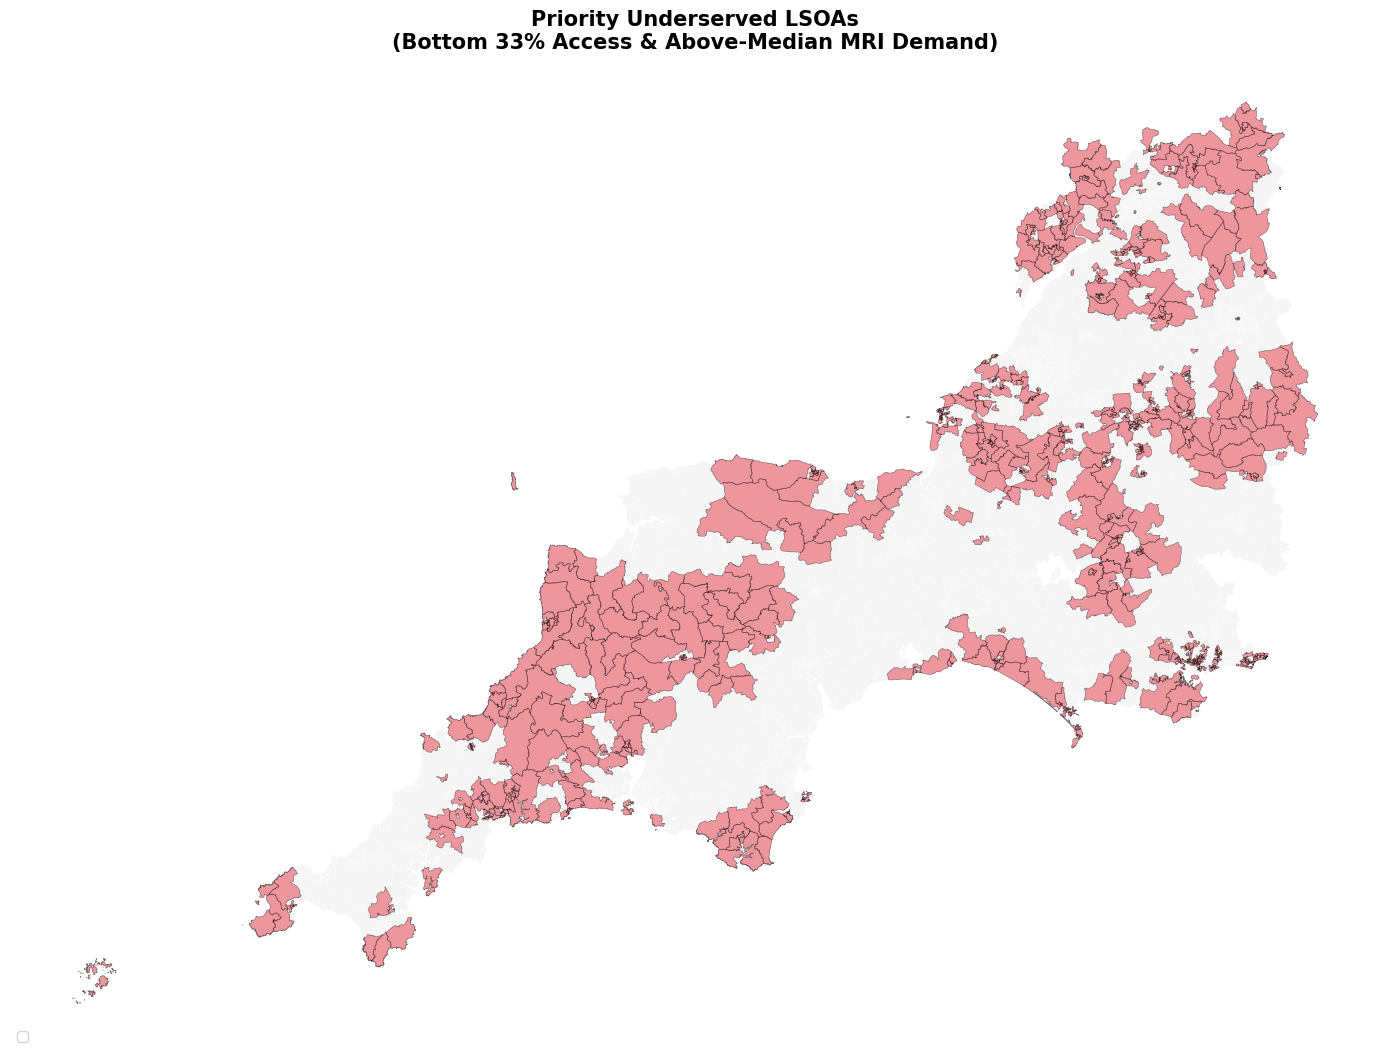

In [14]:
# ----------------------------------------------------------
# Step 2a – Visualise Priority Underserved LSOAs (Preferred Style) — MRI
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# Reproject for alignment
gdf_lsoa_plot = gdf_lsoa.to_crs(epsg=3857)
gdf_priority = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == True]
cdc_gdf_3857 = cdc_gdf.to_crs(epsg=3857)
acute_gdf_3857 = acute_gdf.to_crs(epsg=3857)

# Set up plot
fig, ax = plt.subplots(figsize=(14, 11))

# Base layer – all LSOAs
gdf_lsoa_plot.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Highlight priority underserved LSOAs
gdf_priority.plot(ax=ax, color="#e63946", edgecolor="black", linewidth=0.4, alpha=0.5)

# Final formatting
ax.set_title(
    "Priority Underserved LSOAs\n(Bottom 33% Access & Above-Median MRI Demand)",
    fontsize=15, weight="bold"
)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("priority_lsoas_mri_facilities_corrected.png", dpi=300, bbox_inches="tight")
plt.show()


In [15]:
# ----------------------------------------------------------
# Step 2b – Propose Total MRI Scanner Uplift Scenarios (5%, 10%, 20%)
# ----------------------------------------------------------

# Calculate current total scanners
current_total_scanners = df_sites_mri["MRI Scanners"].sum()
print(f"Current total MRI scanners: {current_total_scanners}")

# Define percentage increases
uplift_factors = [0.05, 0.10, 0.20]

# Create scenario summary table
uplift_summary = []

for factor in uplift_factors:
    new_total = round(current_total_scanners * (1 + factor))
    uplift = new_total - current_total_scanners
    uplift_summary.append({
        "Scenario": f"+{int(factor * 100)}%",
        "New Total MRI Scanners": new_total,
        "Uplift": uplift
    })

# Convert to DataFrame for display
df_uplift = pd.DataFrame(uplift_summary)
print(df_uplift)


Current total MRI scanners: 74
  Scenario  New Total MRI Scanners  Uplift
0      +5%                      78       4
1     +10%                      81       7
2     +20%                      89      15


In [17]:
import math
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans

# --- Config ---
ISLES_OF_SCILLY_CODE = "E01019077"
MIN_CLUSTER_SIZE = 50
MAX_CLUSTER_SIZE = 500
DIAG = False  # set True for extra diagnostics

def generate_clustered_scenario_sites_v3(
    gdf_priority: gpd.GeoDataFrame,
    gpkg_path_master: str,
    travel_matrix_path: str,      # pass the DENSE matrix here (e.g., LSOA_to_LSOA_complete.csv)
    scenario_configs: dict,       # {label: {"n_clusters": k, "scanner_allocation": [...]}, ...}
    score_col: str = "enhanced_3sfca_score_mri",
    demand_col: str = "mri_total_demand",
    scanner_field: str = "MRI Scanners"   # <-- set to "MRI Scanners" for MRI runs
) -> dict:
    """
    Cluster priority LSOAs and pick, per cluster, the LSOA that minimises the SUM of
    car travel time FROM that LSOA to others in the same cluster (medoid-by-sum).

    - Uses a dense LSOA→LSOA matrix (no ≤60 pre-filters).
    - Auto-adjusts n_clusters to respect 50–500 LSOAs per cluster.
    - Excludes Isles of Scilly to avoid outlier effects.
    - Writes the chosen scanner count into both `scanner_field` and a generic `scanner_count`.

    Returns: {scenario_label: GeoDataFrame of proposed sites}
    """
    # --- Base geometry / centroids (BNG) ---
    gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]

    # Normalise IDs and exclude IoS BEFORE clustering
    gdf_priority = gdf_priority.copy()
    gdf_priority["lsoa21cd"] = gdf_priority["lsoa21cd"].astype(str).str.strip()
    gdf_priority = gdf_priority[gdf_priority["lsoa21cd"] != ISLES_OF_SCILLY_CODE]
    gdf_priority = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")

    # Ensure demand/score columns exist
    for col in [demand_col, score_col]:
        if col not in gdf_priority.columns:
            raise KeyError(f"Column '{col}' not found in gdf_priority.")

    # --- Load travel matrix and normalise columns/keys ---
    df_tt = pd.read_csv(travel_matrix_path)
    rename_map = {}
    if "origin_lsoa" in df_tt.columns:         rename_map["origin_lsoa"] = "origin_name"
    if "dest_lsoa" in df_tt.columns:           rename_map["dest_lsoa"] = "destination_name"
    if "car_travel_minutes" in df_tt.columns:  rename_map["car_travel_minutes"] = "travel_time_car"
    df_tt = df_tt.rename(columns=rename_map)

    required = {"origin_name", "destination_name", "travel_time_car"}
    missing = required - set(df_tt.columns)
    if missing:
        raise KeyError(f"Travel matrix missing columns: {missing}")

    # Normalise IDs and EXCLUDE IoS from OD matrix
    for c in ["origin_name", "destination_name"]:
        df_tt[c] = df_tt[c].astype(str).str.strip()
    df_tt = df_tt[
        (df_tt["origin_name"] != ISLES_OF_SCILLY_CODE) &
        (df_tt["destination_name"] != ISLES_OF_SCILLY_CODE)
    ].copy()
    df_tt["travel_time_car"] = pd.to_numeric(df_tt["travel_time_car"], errors="coerce")

    # Number of LSOAs available for clustering (with coords)
    N_all = len(gdf_priority.dropna(subset=["bng_e", "bng_n"]))

    scenario_outputs = {}

    for scenario, config in scenario_configs.items():
        print(f"\nScenario: {scenario}")

        # Requested k and allocation
        k_requested = int(config["n_clusters"])
        alloc_requested = list(config["scanner_allocation"])

        # Derive feasible k range from size policy (50–500)
        k_min = max(1, math.ceil(N_all / MAX_CLUSTER_SIZE))   # ensures clusters ≤ 500
        k_max = max(1, math.floor(N_all / MIN_CLUSTER_SIZE))  # ensures clusters ≥ 50

        # Clamp requested k into [k_min, k_max]
        k = min(max(k_requested, k_min), k_max)
        if k != k_requested:
            print(f"[INFO] Adjusted n_clusters {k_requested} → {k} to respect ~{MIN_CLUSTER_SIZE}–{MAX_CLUSTER_SIZE} LSOAs/cluster (N={N_all}).")

        # Keep scanner allocation length in sync with k
        alloc = alloc_requested.copy()
        if len(alloc) < k:
            alloc += [alloc[-1]] * (k - len(alloc))  # pad with last value
        elif len(alloc) > k:
            alloc = alloc[:k]                        # trim

        # Prepare data for clustering (drop rows lacking coords)
        gdf_scenario = gdf_priority.dropna(subset=["bng_e", "bng_n"]).copy()
        coords = gdf_scenario[["bng_e", "bng_n"]].to_numpy()

        # Run KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        gdf_scenario["cluster"] = kmeans.fit_predict(coords)
        sizes = gdf_scenario.groupby("cluster").size().to_dict()
        print("Cluster sizes:", sizes)

        cluster_sites = []
        skipped_clusters = 0
        relaxed_clusters = 0

        for cluster_id in range(k):
            # Members of this cluster
            cluster_lsoas_all = gdf_scenario[gdf_scenario["cluster"] == cluster_id].copy()
            tiny_cluster = (len(cluster_lsoas_all) < MIN_CLUSTER_SIZE)

            # Belt & braces exclusion of IoS (should already be gone)
            cluster_lsoas = cluster_lsoas_all[
                cluster_lsoas_all["lsoa21cd"].astype(str).str.strip() != ISLES_OF_SCILLY_CODE
            ]
            if cluster_lsoas.empty:
                cluster_lsoas = cluster_lsoas_all.copy()

            lsoa_ids = cluster_lsoas["lsoa21cd"].astype(str).str.strip().tolist()

            # 1) Prefer intra-cluster OD pairs unless the cluster is tiny
            if not tiny_cluster:
                df_sub = df_tt[
                    df_tt["origin_name"].isin(lsoa_ids)
                    & df_tt["destination_name"].isin(lsoa_ids)
                    & (df_tt["origin_name"] != df_tt["destination_name"])
                ]
            else:
                df_sub = pd.DataFrame()  # force relaxation for tiny clusters

            # Coverage diagnostics
            if not df_sub.empty:
                n = len(lsoa_ids)
                expected_pairs = n * (n - 1)
                actual_pairs = len(df_sub)
                if DIAG and (actual_pairs != expected_pairs or df_sub["travel_time_car"].isna().any()):
                    missing_pairs = expected_pairs - actual_pairs
                    print(f"Cluster {cluster_id}: incomplete intra-cluster pairs ({actual_pairs}/{expected_pairs}; missing {missing_pairs}).")
            elif not tiny_cluster:
                print(f"Cluster {cluster_id}: no intra-cluster pairs; relaxing destinations.")
                relaxed_clusters += 1

            # 2) If empty, relax destinations (origins in cluster, dest anywhere)
            if df_sub.empty:
                df_sub = df_tt[
                    df_tt["origin_name"].isin(lsoa_ids)
                    & (df_tt["origin_name"] != df_tt["destination_name"])
                ]

            # 3) If still empty, fallback to first eligible LSOA
            if df_sub.empty:
                print(f"Cluster {cluster_id}: still no pairs. Fallback used.")
                fallback = cluster_lsoas.iloc[0]
                site_row = gdf_centroids[gdf_centroids["lsoa21cd"] == fallback["lsoa21cd"]].copy()
                site_row["travel_time_sum"] = np.nan
                site_row["travel_time_mean"] = np.nan
                site_row["top5_lsoa21cd"] = ""
                site_row["top5_sum_min"]  = ""
                site_row["top5_mean_min"] = ""
                skipped_clusters += 1
            else:
                # Sum & mean travel time FROM each origin (cluster member)
                agg = (
                    df_sub.groupby("origin_name")["travel_time_car"]
                          .agg(total_tt="sum", n="size")
                          .reset_index()
                          .rename(columns={"origin_name": "lsoa21cd"})
                )
                agg["mean_tt"] = agg["total_tt"] / agg["n"]

                # Keep only origin candidates in this cluster
                agg = agg.merge(cluster_lsoas[["lsoa21cd"]], on="lsoa21cd", how="inner")

                # Top 5 by total time (for transparency only)
                top5 = agg.sort_values("total_tt", ascending=True).head(5).copy()

                # Pick minimal total travel time (primary criterion)
                best_lsoa = top5.iloc[0]
                site_row = gdf_centroids[gdf_centroids["lsoa21cd"] == best_lsoa["lsoa21cd"]].copy()
                site_row["travel_time_sum"]  = float(best_lsoa["total_tt"])
                site_row["travel_time_mean"] = float(best_lsoa["mean_tt"])
                site_row["top5_lsoa21cd"] = ",".join(top5["lsoa21cd"].tolist())
                site_row["top5_sum_min"]  = ",".join([f"{v:.2f}" for v in top5["total_tt"].tolist()])
                site_row["top5_mean_min"] = ",".join([f"{v:.2f}" for v in top5["mean_tt"].tolist()])

            # --- metadata for this cluster site ---
            site_row["centroid_point"]   = site_row.geometry.centroid
            site_row["total_demand"]     = cluster_lsoas_all[demand_col].sum()
            site_row["avg_access_score"] = cluster_lsoas_all[score_col].mean()
            site_row["lsoa_count"]       = len(cluster_lsoas_all)
            site_row["cluster"]          = cluster_id

            # Write scanner allocation into both named field and a generic one
            site_row[scanner_field]      = alloc[cluster_id]
            site_row["scanner_count"]    = alloc[cluster_id]

            site_row["Site Name"]        = f"Scenario Site {cluster_id + 1}"
            site_row["Type"]             = f"Scenario {scenario}"

            cluster_sites.append(site_row)

        # Combine clusters → sites GeoDataFrame
        gdf_sites = pd.concat(cluster_sites, ignore_index=True)
        gdf_sites = gpd.GeoDataFrame(gdf_sites, geometry="geometry", crs="EPSG:27700")

        print(f"Clusters processed: {k} | Relaxed: {relaxed_clusters} | Fallbacks: {skipped_clusters}")
        if "travel_time_sum" in gdf_sites.columns:
            print(f"Travel Time Summary (SUM):\n{gdf_sites['travel_time_sum'].describe().round(3)}")
        if "travel_time_mean" in gdf_sites.columns:
            print(f"Travel Time Summary (MEAN):\n{gdf_sites['travel_time_mean'].describe().round(3)}")

        scenario_outputs[scenario] = gdf_sites

    return scenario_outputs



Scenario: +5%
Cluster sizes: {0: 154, 1: 159, 2: 184, 3: 165}
Cluster 0: no intra-cluster pairs; relaxing destinations.
Cluster 1: no intra-cluster pairs; relaxing destinations.
Cluster 2: no intra-cluster pairs; relaxing destinations.
Cluster 3: no intra-cluster pairs; relaxing destinations.
Clusters processed: 4 | Relaxed: 4 | Fallbacks: 0
Travel Time Summary (SUM):
count     4.000
mean     34.599
std       9.953
min      23.723
25%      30.375
50%      33.426
75%      37.651
max      47.820
Name: travel_time_sum, dtype: float64
Travel Time Summary (MEAN):
count     4.000
mean     28.622
std       5.590
min      23.723
25%      23.863
50%      28.251
75%      33.009
max      34.261
Name: travel_time_mean, dtype: float64


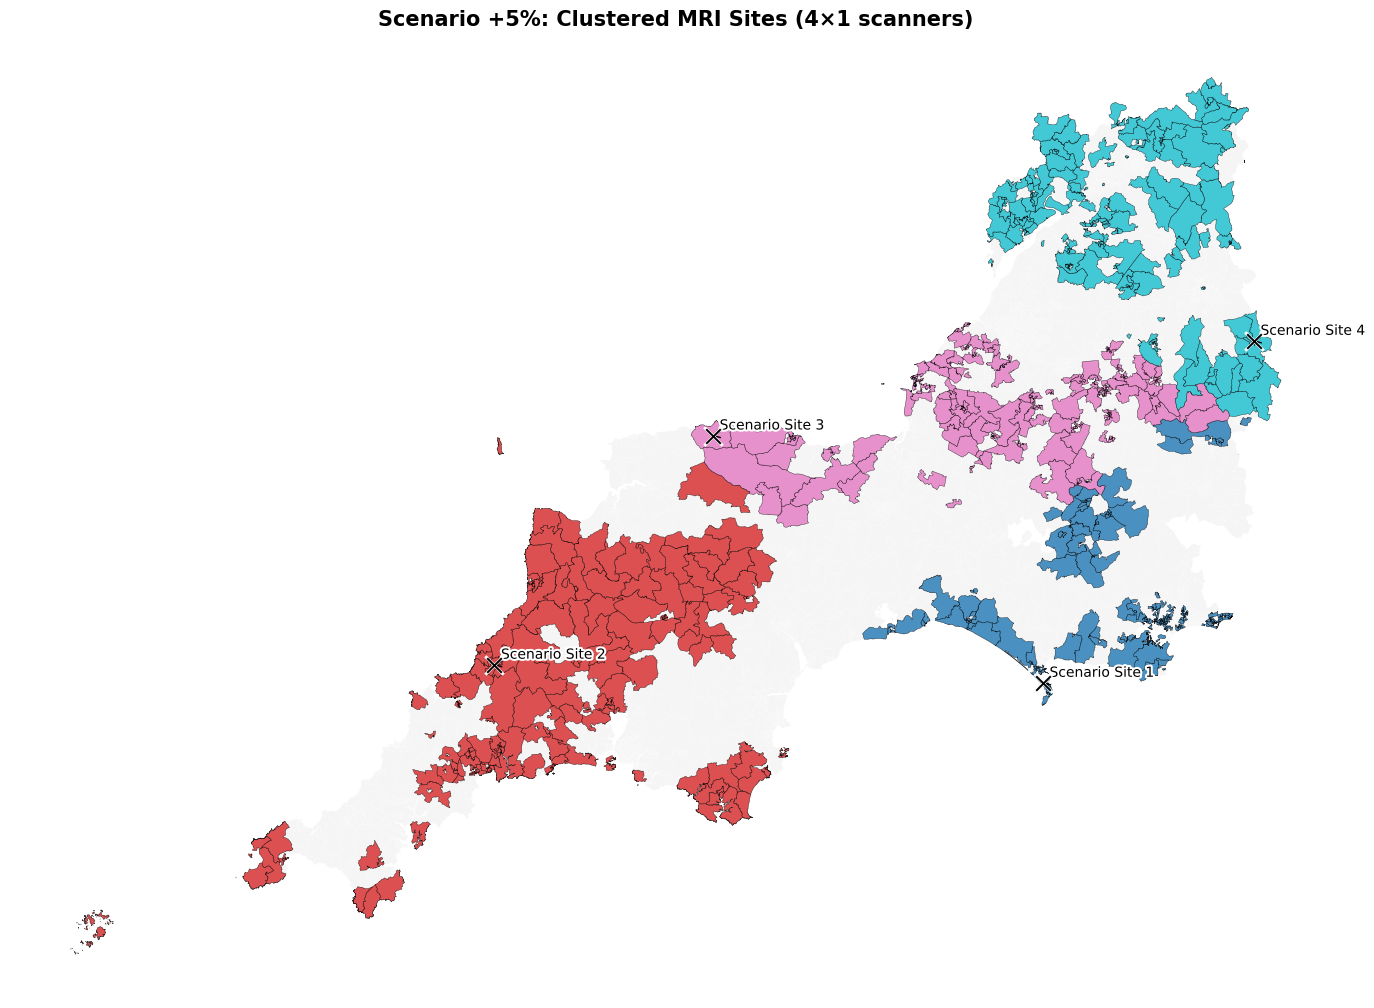

In [18]:
# ----------------------------------------------------------
# Step 3a – Visualise Scenario +5% with Clusters (MRI)
# (site markers = black crosses with white halo)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Config
config_5 = {"+5%": {"n_clusters": 4, "scanner_allocation": [1, 1, 1, 1]}}
n_clusters = config_5["+5%"]["n_clusters"]

# Generate MRI scenario sites (note the MRI columns + scanner field)
sites_5pct = generate_clustered_scenario_sites_v3(
    gdf_priority=gdf_priority,
    gpkg_path_master=gpkg_path_master,
    travel_matrix_path=travel_matrix_path,          # dense OD if available
    scenario_configs=config_5,
    score_col="enhanced_3sfca_score_mri",
    demand_col="mri_total_demand",
    scanner_field="MRI Scanners"
)["+5%"]

# Recluster for visual clusters
gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
gdf_priority_joined = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")
gdf_priority_joined.set_geometry("geometry_y", inplace=True)

coords = gdf_priority_joined[["bng_e", "bng_n"]].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority_joined["cluster"] = kmeans.fit_predict(coords)

# Reproject
gdf_lsoa_proj   = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_proj = gdf_priority_joined.to_crs(epsg=3857)
sites_5pct_proj = sites_5pct.to_crs(epsg=3857)
sites_5pct_proj["centroid_point"] = sites_5pct["centroid_point"].to_crs(epsg=3857)

# Colour map
cmap = cm.get_cmap("tab10", n_clusters)

# Plot
fig, ax = plt.subplots(figsize=(14, 11))
gdf_lsoa_proj.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Plot clusters
for cluster_id in range(n_clusters):
    gdf_cluster = gdf_priority_proj[gdf_priority_proj["cluster"] == cluster_id]
    gdf_cluster.plot(
        ax=ax,
        color=mcolors.to_hex(cmap(cluster_id)),
        edgecolor="black",
        linewidth=0.3,
        alpha=0.8,
        label=f"Cluster {cluster_id + 1}"
    )

# Plot scenario site markers as BLACK CROSSES with WHITE HALO
site_label_added = False
site_size = 110  # base marker size; adjust as needed

for _, row in sites_5pct_proj.iterrows():
    pt = row["centroid_point"]

    # White halo (underlay)
    ax.scatter(
        pt.x, pt.y,
        marker="x",
        s=site_size * 1.6,
        color="white",
        linewidth=2.2,
        zorder=6
    )

    # Black cross (overlay)
    ax.scatter(
        pt.x, pt.y,
        marker="x",
        s=site_size,
        color="black",
        linewidth=1.4,
        zorder=7,
        label="Scenario Site" if not site_label_added else None
    )
    site_label_added = True

    # Label with a white-stroked text halo for readability
    ax.annotate(
        row["Site Name"],
        xy=(pt.x, pt.y),
        xytext=(pt.x + 3000, pt.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Final styling
ax.set_title("Scenario +5%: Clustered MRI Sites (4×1 scanners)", fontsize=15, weight="bold")
ax.axis("off")
plt.tight_layout()
plt.savefig("scenario_5pct_MRI_cluster_colours.png", dpi=300, bbox_inches="tight")
plt.show()



Scenario: +10%
Cluster sizes: {0: 143, 1: 93, 2: 135, 3: 116, 4: 106, 5: 69}
Cluster 0: no intra-cluster pairs; relaxing destinations.
Cluster 1: no intra-cluster pairs; relaxing destinations.
Cluster 2: no intra-cluster pairs; relaxing destinations.
Cluster 3: no intra-cluster pairs; relaxing destinations.
Cluster 4: no intra-cluster pairs; relaxing destinations.
Cluster 5: no intra-cluster pairs; relaxing destinations.
Clusters processed: 6 | Relaxed: 6 | Fallbacks: 0
Travel Time Summary (SUM):
count     6.000
mean     44.447
std      17.381
min      23.723
25%      33.009
50%      41.041
75%      56.327
max      69.121
Name: travel_time_sum, dtype: float64
Travel Time Summary (MEAN):
count     6.000
mean     29.771
std       4.940
min      23.723
25%      25.328
50%      31.087
75%      33.844
max      34.560
Name: travel_time_mean, dtype: float64


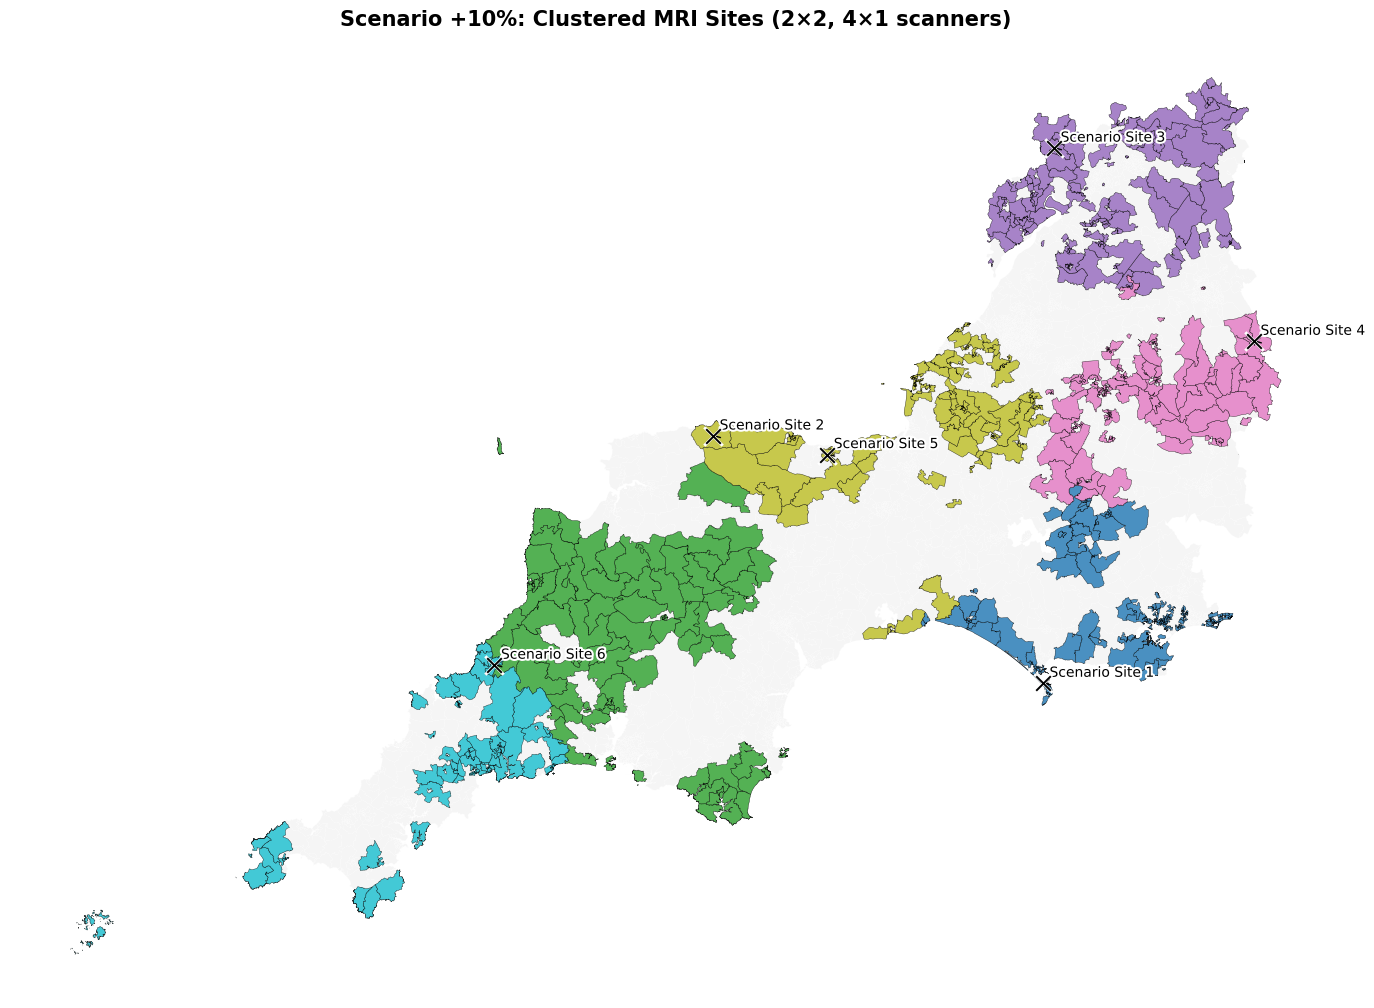

In [19]:
# ----------------------------------------------------------
# Step 3b – Visualise Scenario +10% with Clusters (MRI)
# (site markers = black crosses with white halo)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define +10% scenario config
config_10 = {"+10%": {"n_clusters": 6, "scanner_allocation": [2, 2, 1, 1, 1, 1]}}
n_clusters = config_10["+10%"]["n_clusters"]

# Generate scenario site locations for MRI
sites_10pct = generate_clustered_scenario_sites_v3(
    gdf_priority=gdf_priority,
    gpkg_path_master=gpkg_path_master,
    travel_matrix_path=travel_matrix_path,          # pass dense OD if available
    scenario_configs=config_10,
    score_col="enhanced_3sfca_score_mri",
    demand_col="mri_total_demand",
    scanner_field="MRI Scanners"
)["+10%"]

# Recluster LSOAs to show colour-coded clusters
gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
gdf_priority_joined = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")
gdf_priority_joined.set_geometry("geometry_y", inplace=True)

# Run KMeans on BNG coords
coords = gdf_priority_joined[["bng_e", "bng_n"]].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority_joined["cluster"] = kmeans.fit_predict(coords)

# Reproject all layers
gdf_lsoa_proj   = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_proj = gdf_priority_joined.to_crs(epsg=3857)
sites_10pct_proj = sites_10pct.to_crs(epsg=3857)
sites_10pct_proj["centroid_point"] = sites_10pct["centroid_point"].to_crs(epsg=3857)

# Colour palette for clusters
cmap = cm.get_cmap("tab10", n_clusters)

# Plot setup
fig, ax = plt.subplots(figsize=(14, 11))

# Base LSOAs
gdf_lsoa_proj.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Plot LSOAs by cluster
for cluster_id in range(n_clusters):
    gdf_cluster = gdf_priority_proj[gdf_priority_proj["cluster"] == cluster_id]
    gdf_cluster.plot(
        ax=ax,
        color=mcolors.to_hex(cmap(cluster_id)),
        edgecolor="black",
        linewidth=0.3,
        alpha=0.8,
        label=f"Cluster {cluster_id + 1}"
    )

# Plot scenario site markers as BLACK CROSSES with WHITE HALO
site_label_added = False
site_size = 110  # adjust to taste

for _, row in sites_10pct_proj.iterrows():
    pt = row["centroid_point"]

    # White halo (underlay)
    ax.scatter(
        pt.x, pt.y,
        marker="x",
        s=site_size * 1.6,
        color="white",
        linewidth=2.2,
        zorder=6
    )

    # Black cross (overlay)
    ax.scatter(
        pt.x, pt.y,
        marker="x",
        s=site_size,
        color="black",
        linewidth=1.4,
        zorder=7,
        label="Scenario Site" if not site_label_added else None
    )
    site_label_added = True

    # Label with white-stroked halo for readability
    ax.annotate(
        row["Site Name"],
        xy=(pt.x, pt.y),
        xytext=(pt.x + 3000, pt.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Final formatting
ax.set_title("Scenario +10%: Clustered MRI Sites (2×2, 4×1 scanners)", fontsize=15, weight="bold")
ax.axis("off")
plt.tight_layout()
plt.savefig("scenario_10pct_MRI_cluster_colours.png", dpi=300, bbox_inches="tight")
plt.show()



Scenario: +20%
Cluster sizes: {0: 124, 1: 42, 2: 95, 3: 136, 4: 104, 5: 40, 6: 59, 7: 62}
Cluster 0: no intra-cluster pairs; relaxing destinations.
Cluster 2: no intra-cluster pairs; relaxing destinations.
Cluster 3: no intra-cluster pairs; relaxing destinations.
Cluster 4: no intra-cluster pairs; relaxing destinations.
Cluster 6: no intra-cluster pairs; relaxing destinations.
Cluster 7: no intra-cluster pairs; relaxing destinations.
Clusters processed: 8 | Relaxed: 6 | Fallbacks: 0
Travel Time Summary (SUM):
count     8.000
mean     47.600
std      15.935
min      23.723
25%      33.844
50%      50.564
75%      59.576
max      69.121
Name: travel_time_sum, dtype: float64
Travel Time Summary (MEAN):
count     8.000
mean     29.461
std       4.332
min      23.723
25%      25.968
50%      29.994
75%      33.009
max      34.560
Name: travel_time_mean, dtype: float64


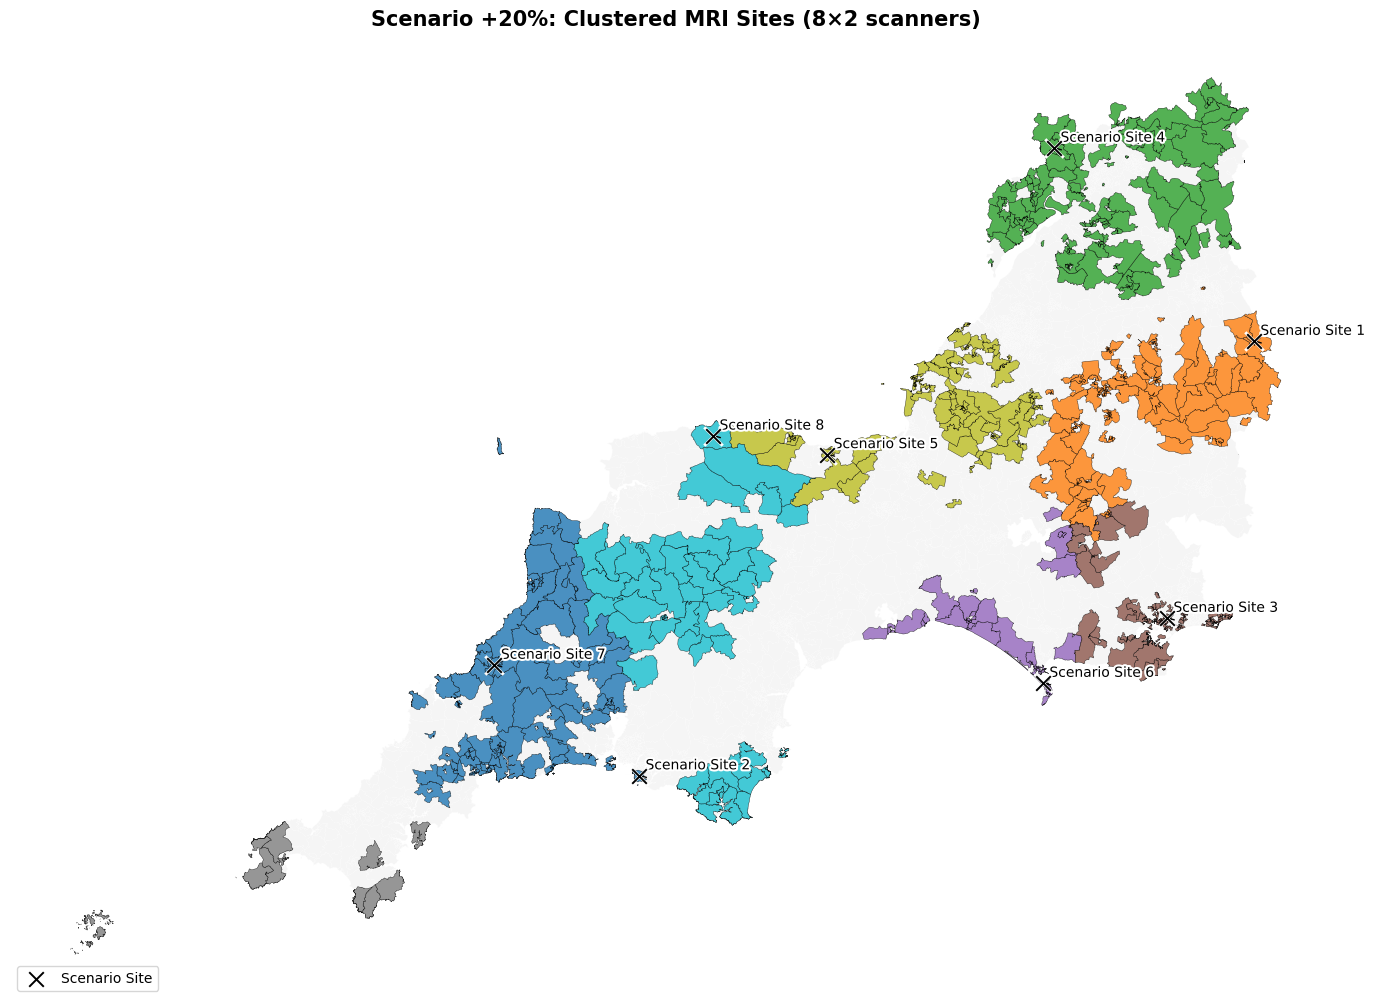

In [20]:
# ----------------------------------------------------------
# Step 3c – Visualise Scenario +20% with Clusters (MRI)
# (site markers switched to black crosses with white halo)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Config (8 clusters, each with 2 scanners)
config_20 = {"+20%": {"n_clusters": 8, "scanner_allocation": [2] * 8}}
n_clusters = config_20["+20%"]["n_clusters"]

# Generate MRI scenario sites
sites_20pct = generate_clustered_scenario_sites_v3(
    gdf_priority=gdf_priority,
    gpkg_path_master=gpkg_path_master,
    travel_matrix_path=travel_matrix_path,
    scenario_configs=config_20,
    score_col="enhanced_3sfca_score_mri",
    demand_col="mri_total_demand"
)["+20%"]

# Recluster (for colouring LSOA clusters on the map)
gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
gdf_priority_joined = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")
gdf_priority_joined.set_geometry("geometry_y", inplace=True)

coords = gdf_priority_joined[["bng_e", "bng_n"]].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority_joined["cluster"] = kmeans.fit_predict(coords)

# Reproject
gdf_lsoa_proj    = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_proj = gdf_priority_joined.to_crs(epsg=3857)
sites_20pct_proj  = sites_20pct.to_crs(epsg=3857)
sites_20pct_proj["centroid_point"] = sites_20pct["centroid_point"].to_crs(epsg=3857)

# Colour map
cmap = cm.get_cmap("tab10", n_clusters)

# Plot
fig, ax = plt.subplots(figsize=(14, 11))
gdf_lsoa_proj.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Plot clusters
for cluster_id in range(n_clusters):
    gdf_cluster = gdf_priority_proj[gdf_priority_proj["cluster"] == cluster_id]
    gdf_cluster.plot(
        ax=ax,
        color=mcolors.to_hex(cmap(cluster_id)),
        edgecolor="black",
        linewidth=0.3,
        alpha=0.8,
        label=f"Cluster {cluster_id + 1}"
    )

# Plot scenario site markers as BLACK CROSSES with WHITE HALO
site_label_added = False
site_size = 110  # base marker size

for _, row in sites_20pct_proj.iterrows():
    pt = row["centroid_point"]

    # White halo (underlay)
    ax.scatter(
        pt.x, pt.y,
        marker="x",
        s=site_size * 1.6,
        color="white",
        linewidth=2.2,
        zorder=6
    )

    # Black cross (overlay)
    ax.scatter(
        pt.x, pt.y,
        marker="x",
        s=site_size,
        color="black",
        linewidth=1.4,
        zorder=7,
        label="Scenario Site" if not site_label_added else None
    )
    site_label_added = True

    # Label with white-stroked halo for readability
    ax.annotate(
        row["Site Name"],
        xy=(pt.x, pt.y),
        xytext=(pt.x + 3000, pt.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Final styling
ax.set_title("Scenario +20%: Clustered MRI Sites (8×2 scanners)", fontsize=15, weight="bold")
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("scenario_20pct_MRI_cluster_colours.png", dpi=300, bbox_inches="tight")
plt.show()


In [21]:
# ----------------------------------------------------------
# Step 4 – Ranked Summary of Proposed MRI Sites per Scenario
# ----------------------------------------------------------

for df in [sites_5pct, sites_10pct, sites_20pct]:
    if "rank" not in df.columns:
        df["rank_score"] = (
            df["total_demand"].rank(ascending=False) +   # more demand = better (lower rank)
            df["avg_access_score"].rank(ascending=True)  # lower access = higher priority
        )
        df["rank"] = df["rank_score"].rank(method="dense").astype(int)

columns_to_show = ["Site Name", "total_demand", "avg_access_score", "rank"]

def print_site_summary(scenario_title, df):
    print(f"\n{scenario_title}")
    missing = [col for col in columns_to_show if col not in df.columns]
    if missing:
        print(f"Missing columns: {missing}")
    else:
        print(df[columns_to_show].sort_values("rank").to_string(index=False))

# +5% Scenario
print_site_summary("+5% Scenario: 4× MRI Sites (1 scanner each)", sites_5pct)

# +10% Scenario
print_site_summary("+10% Scenario: 6× MRI Sites (2×2, 4×1 scanners)", sites_10pct)

# +20% Scenario
print_site_summary("+20% Scenario: 8× MRI Sites (2 scanners each)", sites_20pct)



+5% Scenario: 4× MRI Sites (1 scanner each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 2  17987.618626          0.000076     1
Scenario Site 3  19918.582177          0.000096     1
Scenario Site 4  18091.006178          0.000087     1
Scenario Site 1  16867.033859          0.000109     2

+10% Scenario: 6× MRI Sites (2×2, 4×1 scanners)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 3  14702.415024          0.000086     1
Scenario Site 2  10748.973548          0.000069     2
Scenario Site 1  15602.903296          0.000109     3
Scenario Site 4  12630.272935          0.000090     3
Scenario Site 6   7579.993557          0.000086     4
Scenario Site 5  11599.682481          0.000104     5

+20% Scenario: 8× MRI Sites (2 scanners each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 4  14815.766556          0.000086     1
Scenario Site 8   7230.237468          0.000066     2
Scenario Site 1  13527.107536          0.000090  

In [27]:
# ----------------------------------------------------------
# Step 5 – Prepare Minimal Outputs for Scenario and Baseline Sites (MRI)
# ----------------------------------------------------------

def to_minimal_sites(df):
    df = df.copy()
    # Normalise LSOA id
    if "nearest_lsoa21cd" in df.columns:
        df = df.rename(columns={"nearest_lsoa21cd": "lsoa21cd"})

    # Coalesce scanner_count from MRI → CT → scanner_count (if already present)
    sc = None
    if "MRI Scanners" in df.columns:
        sc = pd.to_numeric(df["MRI Scanners"], errors="coerce")
    elif "CT Scanners" in df.columns:
        sc = pd.to_numeric(df["CT Scanners"], errors="coerce")
    elif "scanner_count" in df.columns:
        sc = pd.to_numeric(df["scanner_count"], errors="coerce")
    else:
        sc = pd.Series(1, index=df.index)  # fallback

    sc = sc.fillna(1).astype(int)

    # Build a clean, minimal frame with unique columns
    out = pd.DataFrame({
        "Site Name": df["Site Name"].astype(str),
        "lsoa21cd": df["lsoa21cd"].astype(str) if "lsoa21cd" in df.columns else None,
        "bng_e": df["bng_e"].astype(float),
        "bng_n": df["bng_n"].astype(float),
        "scanner_count": sc
    })
    return out

# Apply to each scenario
sites_5  = to_minimal_sites(sites_5pct)
sites_10 = to_minimal_sites(sites_10pct)
sites_20 = to_minimal_sites(sites_20pct)

# Sanity check prints (no duplicate columns now)
print("\n+5% MRI scenario — sites × scanners")
print(sites_5[["Site Name", "scanner_count"]].to_string(index=False))

print("\n+10% MRI scenario — sites × scanners")
print(sites_10[["Site Name", "scanner_count"]].to_string(index=False))

print("\n+20% MRI scenario — sites × scanners")
print(sites_20[["Site Name", "scanner_count"]].to_string(index=False))



+5% MRI scenario — sites × scanners
      Site Name  scanner_count
Scenario Site 1              1
Scenario Site 2              1
Scenario Site 3              1
Scenario Site 4              1

+10% MRI scenario — sites × scanners
      Site Name  scanner_count
Scenario Site 1              2
Scenario Site 2              2
Scenario Site 3              1
Scenario Site 4              1
Scenario Site 5              1
Scenario Site 6              1

+20% MRI scenario — sites × scanners
      Site Name  scanner_count
Scenario Site 1              2
Scenario Site 2              2
Scenario Site 3              2
Scenario Site 4              2
Scenario Site 5              2
Scenario Site 6              2
Scenario Site 7              2
Scenario Site 8              2


In [28]:
# ----------------------------------------------------------
# Step 6 – Prepare Minimal Baseline Sites (CDC + Acute) — MRI
# ----------------------------------------------------------

import geopandas as gpd
import pandas as pd

# Load capability files
df_acute = pd.read_csv(acute_path)
df_cdc   = pd.read_csv(cdc_path)

# Use MRI Scanners for BOTH Acute and CDC
for df in (df_acute, df_cdc):
    df["scanner_count"] = (
        pd.to_numeric(df["MRI Scanners"], errors="coerce")
          .fillna(0)
          .astype(int)
    )

# Keep MRI sites with valid coordinates
df_acute = df_acute[(df_acute["scanner_count"] > 0) & df_acute["latitude"].notna() & df_acute["longitude"].notna()]
df_cdc   = df_cdc  [(df_cdc["scanner_count"] > 0) & df_cdc["latitude"].notna() & df_cdc["longitude"].notna()]

# Tag site type
df_acute["site_type"] = "Acute"
df_cdc["site_type"]   = "CDC"

# Standardise columns
cols_needed = ["Name", "scanner_count", "site_type", "lsoa21cd", "latitude", "longitude"]
df_acute = df_acute[cols_needed].copy()
df_cdc   = df_cdc[cols_needed].copy()

# Combine and rename
df_all = pd.concat([df_acute, df_cdc], ignore_index=True).rename(columns={"Name": "site_name"})

# GeoDataFrame (lon, lat → geometry), project to BNG
gdf_baseline = gpd.GeoDataFrame(
    df_all,
    geometry=gpd.points_from_xy(df_all["longitude"], df_all["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=27700)

# Add BNG coords
gdf_baseline["bng_e"] = gdf_baseline.geometry.x
gdf_baseline["bng_n"] = gdf_baseline.geometry.y

# Final minimal table
baseline_sites = gdf_baseline[[
    "site_name", "scanner_count", "site_type", "lsoa21cd", "bng_e", "bng_n", "geometry"
]].copy()

print("Baseline MRI sites shape:", baseline_sites.shape)
display(baseline_sites.head())


Baseline MRI sites shape: (33, 7)


,site_name,scanner_count,site_type,lsoa21cd,bng_e,bng_n,geometry
0,Cheltenham General Hospital,2,Acute,E01022116,7.549455e+06,-5.917795e+06,POINT (7549454.977 -5917795.016)
1,Gloucestershire Royal Hospital,2,Acute,E01022312,7.543011e+06,-5.947684e+06,POINT (7543011.153 -5947684.423)
2,Musgrove Park Hospital,2,Acute,E01029302,7.372655e+06,-6.102918e+06,POINT (7372655.066 -6102918.233)
3,Yeovil District Hospital,2,Acute,E01029231,7.366354e+06,-6.012574e+06,POINT (7366354.119 -6012574.417)
4,Bristol Royal Infirmary,6,Acute,E01033904,7.462448e+06,-6.011347e+06,POINT (7462448.343 -6011347.323)


In [29]:
# ----------------------------------------------------------
# Step 7 – Prepare Minimal Output for Baseline Sites (CDC + Acute) — MRI
# ----------------------------------------------------------

# Start from baseline_sites (already built in Step 6)
baseline_proj = baseline_sites.copy()

# Ensure CRS is BNG and BNG coords exist
if baseline_proj.crs is None or baseline_proj.crs.to_epsg() != 27700:
    baseline_proj = baseline_proj.to_crs(epsg=27700)
if not {"bng_e", "bng_n"}.issubset(baseline_proj.columns):
    baseline_proj["bng_e"] = baseline_proj.geometry.x
    baseline_proj["bng_n"] = baseline_proj.geometry.y

# Keep actual LSOA if available; otherwise fill with None
lsoa_series = (
    baseline_proj["lsoa21cd"].astype(str)
    if "lsoa21cd" in baseline_proj.columns
    else pd.Series([None] * len(baseline_proj), index=baseline_proj.index)
)

# Build minimal table
baseline_simple = (
    baseline_proj
      .rename(columns={"site_name": "Site Name"})
      .assign(lsoa21cd=lsoa_series)
      [["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]]
      .copy()
)

# Optional: ensure scanner_count is integer
baseline_simple["scanner_count"] = pd.to_numeric(baseline_simple["scanner_count"], errors="coerce").fillna(0).astype(int)

print("Baseline (MRI) minimal table:")
display(baseline_simple.head())


Baseline (MRI) minimal table:


,Site Name,lsoa21cd,bng_e,bng_n,scanner_count
0,Cheltenham General Hospital,E01022116,7.549455e+06,-5.917795e+06,2
1,Gloucestershire Royal Hospital,E01022312,7.543011e+06,-5.947684e+06,2
2,Musgrove Park Hospital,E01029302,7.372655e+06,-6.102918e+06,2
3,Yeovil District Hospital,E01029231,7.366354e+06,-6.012574e+06,2
4,Bristol Royal Infirmary,E01033904,7.462448e+06,-6.011347e+06,6


In [30]:
# ----------------------------------------------------------
# Step 8 – Export All Minimal Files to CSV (MRI naming)
# ----------------------------------------------------------
import os

# Ensure baseline_simple has the same structure
baseline_simple = baseline_sites.rename(columns={
    "site_name": "Site Name"
})[["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]].copy()

# Combine baseline with each scenario
sites_5_combined  = pd.concat([sites_5,  baseline_simple], ignore_index=True)
sites_10_combined = pd.concat([sites_10, baseline_simple], ignore_index=True)
sites_20_combined = pd.concat([sites_20, baseline_simple], ignore_index=True)

# ----------------------------------------------------------
# Step 9 – Export Combined CSVs to Scenario Folder (MRI)
# ----------------------------------------------------------
output_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/E3SFCA_Scenarios"
os.makedirs(output_dir, exist_ok=True)

# MRI-specific filenames
sites_5_combined.to_csv (f"{output_dir}/scenario_5pct_plus_baseline_mri.csv",  index=False)
sites_10_combined.to_csv(f"{output_dir}/scenario_10pct_plus_baseline_mri.csv", index=False)
sites_20_combined.to_csv(f"{output_dir}/scenario_20pct_plus_baseline_mri.csv", index=False)

# Standalone baseline (MRI)
baseline_simple.to_csv(f"{output_dir}/baseline_mri_sites.csv", index=False)

print("MRI scenario and baseline CSVs saved to E3SFCA_Scenarios folder.")


MRI scenario and baseline CSVs saved to E3SFCA_Scenarios folder.
